In [2]:
from models import FasterRCNN, FasterRCNN_RPNLoss, FasterRCNN_FastLoss, TransformBBox
from dataset import VOCDataset
from dataloader import get_dataloader
import utils as U
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import pickle
import torch

/tmp/ipykernel_996532/487605389.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('outputs/checkpoint_step1_69999.pt', map_location='cpu')


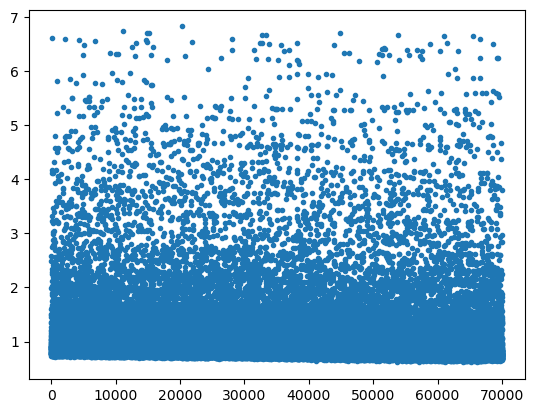

In [3]:
state = torch.load('outputs/checkpoint_step1_69999.pt', map_location='cpu')
plt.plot([x.item() for x in state['losses']], '.')

In [30]:
model = FasterRCNN()
model.load_state_dict(state['model'])
ds = VOCDataset(2007, 'trainval')

In [31]:
dl, _ =get_dataloader(ds, shuffle=False, augment=False, normalize=False)

batch = next(dl)
model.train()
outputs, targets = model(batch['x'], batch['y'])
loss = FasterRCNN_RPNLoss()(outputs, targets)
print(loss)

tensor(0.9741, grad_fn=<AddBackward0>)


In [32]:
outputs['rpn_anchors']
outputs['rpn_bbox_reg']

tensor([[ 0.0641,  0.0253, -0.0103,  0.0399],
        [ 0.0309,  0.0269, -0.0012, -0.0143],
        [ 0.0763,  0.0529,  0.0495,  0.1153],
        ...,
        [-0.0328,  0.0044,  0.0081, -0.0042],
        [ 0.0656, -0.0021,  0.0077,  0.0573],
        [-0.0718,  0.0132,  0.0159, -0.0691]], grad_fn=<IndexBackward0>)

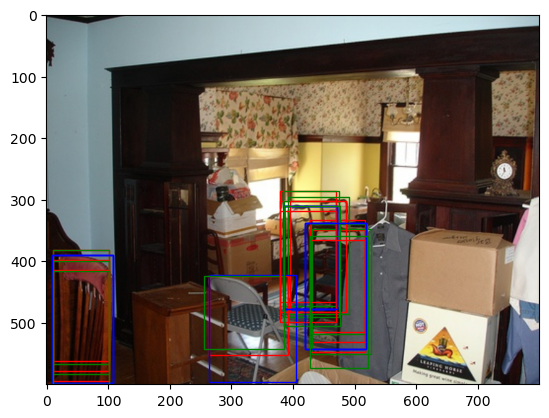

In [34]:
gt = outputs['rpn_gtbboxes']
an = outputs['rpn_anchors']
iu = outputs['rpn_iou']
ro = outputs['rpn_roi']

an = U.xyxy_2_xywh(an)
gt = U.xyxy_2_xywh(gt)
ro = U.xyxy_2_xywh(ro)

for i in range(an.size(0)):
    if iu[i] < .65:
        continue
    x1,y1,w1,h1 = an[i].numpy()
    x2,y2,w2,h2 = gt[i].numpy()
    x3,y3,w3,h3 = ro[i].numpy()
    # print(x3,y3,w3,h3)
    plt.gca().add_patch(patch.Rectangle((x1,y1), w1, h1, ec='red', fc='none'))
    plt.gca().add_patch(patch.Rectangle((x2,y2), w2, h2, ec='blue', fc='none'))
    plt.gca().add_patch(patch.Rectangle((x3,y3), w3, h3, ec='green', fc='none'))
    

im = batch['x'][0][0].permute(1,2,0)
plt.imshow(im)

tensor(0.7309)
tensor(0.7956)
tensor(0.7956)
tensor(0.7403)
tensor(0.8403)
tensor(0.7738)
tensor(0.7202)
tensor(0.7873)
tensor(0.8155)
tensor(0.7794)


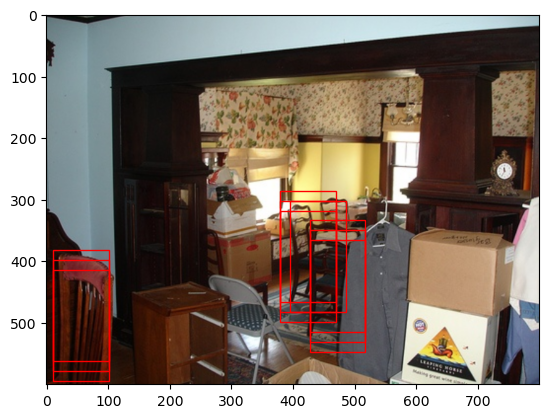

In [19]:
im = batch['x'][0][0].permute(1,2,0)
for anchor in outputs['rpn_anchors_all']:
    i = 0
    for gt in batch['y']['bboxes'][0]:
        i = max(i,U.iou(anchor,gt))
    if i > .7:
        print(i)
        x1,y1,x2,y2 = anchor.ravel().numpy()
        w = x2-x1
        h = y2-y1
        plt.gca().add_patch(patch.Rectangle((x1,y1), w, h, ec='red', fc='none'))
    #     print(i)
    #     break
plt.imshow(im)

In [8]:
(outputs['rpn_iou'] > .5).sum()

tensor(89)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


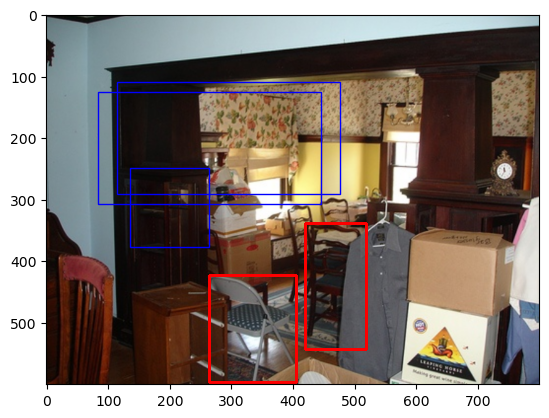

In [26]:
im = batch['x'][0][0].permute(1,2,0)

xywh = U.xyxy_2_xywh(outputs['rpn_anchors'])
gt = U.xyxy_2_xywh(batch['y']['gt_bboxes'])
ious = outputs['rpn_iou']

cls = outputs['rpn_cls_target']
print(cls)
for i in range(gt.size(0)):
    x,y,w,h = gt[i].numpy()
    p = patch.Rectangle((x,y),w,h,ec='red', fc='none')
    plt.gca().add_patch(p)

for i in range(gt.size(0)):
    if ious[i] <= .7:
        continue
    x,y,w,h = xywh[i].numpy()
    p = patch.Rectangle((x,y),w,h,ec='blue', fc='none')
    plt.gca().add_patch(p)
plt.imshow(im)

In [17]:
for i in range(gt.size(0)):
    for j in range()

False

In [18]:
outputs['rpn_anchors']

tensor([[378.7452, 301.4903, 469.2548, 482.5097],
        [378.7452, 317.4903, 469.2548, 498.5097],
        [426.7452, 333.4903, 517.2548, 514.5096],
        ...,
        [253.4903, 394.7452, 434.5097, 485.2548],
        [ 13.9613, 194.9807, 738.0387, 557.0193],
        [258.9807,  29.4903, 621.0193, 210.5097]])